In [ ]:
import numpy as np
import pandas as pd
import statsmodels
import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import statsmodels.tsa.stattools as ts
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns; sns.set(style="whitegrid")

## Setting up our Data

Before we begin building our model, we need to gather our data. I've decided to use a five-year time window, starting in 2017 and ending in 2022. Next, we're going to pull a list of all stocks on the S&P 500 from wikipedia. What is useful about this list is that it categorizes them by Industry which can make various means of analysis easier.

In [71]:
start = dt.datetime(2017, 1, 1)
end = dt.datetime(2022, 1, 1)

url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tables = pd.read_html(url)
sp500 = pd.DataFrame(tables[0])
sp500 = sp500.rename(columns = {'GICS Sector':'Sector', 'GICS Sub-Industry':'Industry'})
sp500.head()

,Symbol,Security,SEC filings,Sector,Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


You can choose to use the whole S&P 500 if you like but for now we will focus on specific industries. That does not mean that you cannot find correlations between stocks across industries, but the processing time required will be significant and you will have to sift through a lot of pairs before you find a good one. Thus, we stick to industries. To first narrow it down by industry, we use <code>DataFrame['Column Name'].unique()</code> to return a NumPy array containing all the unique terms in that column.

In [72]:
sp500['Sector'].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Communication Services', 'Consumer Staples',
       'Consumer Discretionary', 'Utilities', 'Financials', 'Materials',
       'Real Estate', 'Energy'], dtype=object)

As we see, there are only 11 Sectors with quite broad definitions, so in order to narrow down our choices, first we choose our sector and then print all unique values under <code>Industry</code> that are in that sector. This is essentially (one of) the Python equivalent of the filter option in Excel.

In [4]:
sp500.loc[(sp500['Sector'] == 'Health Care')]['Industry'].unique()

array(['Health Care Equipment', 'Pharmaceuticals', 'Health Care Supplies',
       'Health Care Distributors', 'Biotechnology', 'Managed Health Care',
       'Life Sciences Tools & Services', 'Health Care Technology',
       'Health Care Services', 'Health Care Facilities'], dtype=object)

Now that we have a list of all the industries contained within the Health Care sector, we can add the various industries classified under Health Care that we might think are comparable. We thus create a new DataFrame called <code>industry</code> which contains only companies in the specific industry(ies) we want.

In [98]:
industry = sp500.loc[(sp500['Industry'] == 'Health Care Equipment')]
industry = industry.append(sp500.loc[(sp500['Industry'] == 'Health Care Distributors')])
industry = industry.append(sp500.loc[(sp500['Industry'] == 'Health Care Supplies')])
industry = industry.append(sp500.loc[(sp500['Industry'] == 'Health Care Technology')])
industry = industry.append(sp500.loc[(sp500['Industry'] == 'Health Care Services')])
industry = industry.append(sp500.loc[(sp500['Industry'] == 'Health Care REITs')])
industry = industry.append(sp500.loc[(sp500['Industry'] == 'Health Care Facilities')])

Now that we've done that, we want to create a list of all the tickers that match our criteria which can be parsed through Pandas DataReader so that we can retrieve the data we want from Yahoo Finance.

In [6]:
tickers = industry['Symbol'].to_list()

Some stocks (for example Berkshire Hathaway class B shares) are listed in Wikpedia with a period "." separating the company ticker from the stock class, while these same stocks are listed on Yahoo Finance with a "-" instead. In the event that some of the stocks you're analyzing are formatted in such a way, this lambda function function reformats the names accordingly.

In [ ]:
for x in tickers:
    tickers.append(x.replace(".","-"))

tickers

We now construct a Pandas DataFrame <code>df</code> of time series data with each row corresponding to the trading day our start date until our end date, and each column corresponding to the Adjusted Close price for the respective stock on that day.

In [7]:
df = pdr.get_data_yahoo(tickers, start, end)['Adj Close']
df.head()

Symbols,ABT,ABMD,A,BAX,BDX,BSX,DHR,DXCM,EW,HOLX,...,CERN,CVS,LH,DGX,PEAK,VTR,WELL,DVA,HCA,UHS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,35.615993,112.360001,44.659351,41.997967,154.439926,21.879999,76.849701,58.250000,31.840000,40.150002,...,47.925964,69.226463,129.070007,83.282021,23.358868,48.522182,52.572762,65.089996,71.650726,104.766701
2017-01-04,35.898731,115.739998,45.245323,42.290928,154.243530,22.080000,77.337440,60.720001,32.180000,40.029999,...,46.499828,68.709526,130.100006,83.840530,23.876560,48.897053,52.977962,66.309998,74.219978,106.828438
2017-01-05,36.208836,114.809998,44.707382,42.574451,154.112579,22.049999,78.049568,62.660000,32.396667,39.790001,...,46.228180,70.148346,129.110001,83.498230,24.433468,49.334396,54.161777,65.709999,73.912064,106.789192
2017-01-06,37.193855,115.419998,46.100292,43.018616,157.002197,22.150000,78.459297,63.230000,32.356667,39.880001,...,46.131161,70.820335,129.339996,83.299057,24.488373,49.240677,54.384239,65.790001,73.729210,106.533913
2017-01-09,37.157372,117.110001,46.244381,43.632900,157.918640,22.190001,78.615356,62.490002,32.650002,40.049999,...,46.558033,70.389557,130.729996,83.670197,24.166780,49.553082,54.344513,63.380001,75.942436,109.508743


Now it's time to pick a pair of stocks. First, we want to construct a correlation matrix for our selection of stocks. Especially with a large number of stocks, a standard correlation matrix containing numbers alone can make it difficult to find the right pair, so we construct a heatmap. The <code>figsize</code> and <code>dpi</code> don't affect the results and are specific to your computer; I am currently writing this on a 24", 4.5K display and have found the below dimensions to look the nicest on my screen but it is ultimately up to personal preference.

There are a few changes that I make here on top of the standard seaborn heatmap. The first is the inclusion of the <code>.abs()</code> function and the second is the use of a mask to show only the lower triangle, both of these steps are done to make the heatmap easier to read.

<AxesSubplot:xlabel='Symbols', ylabel='Symbols'>

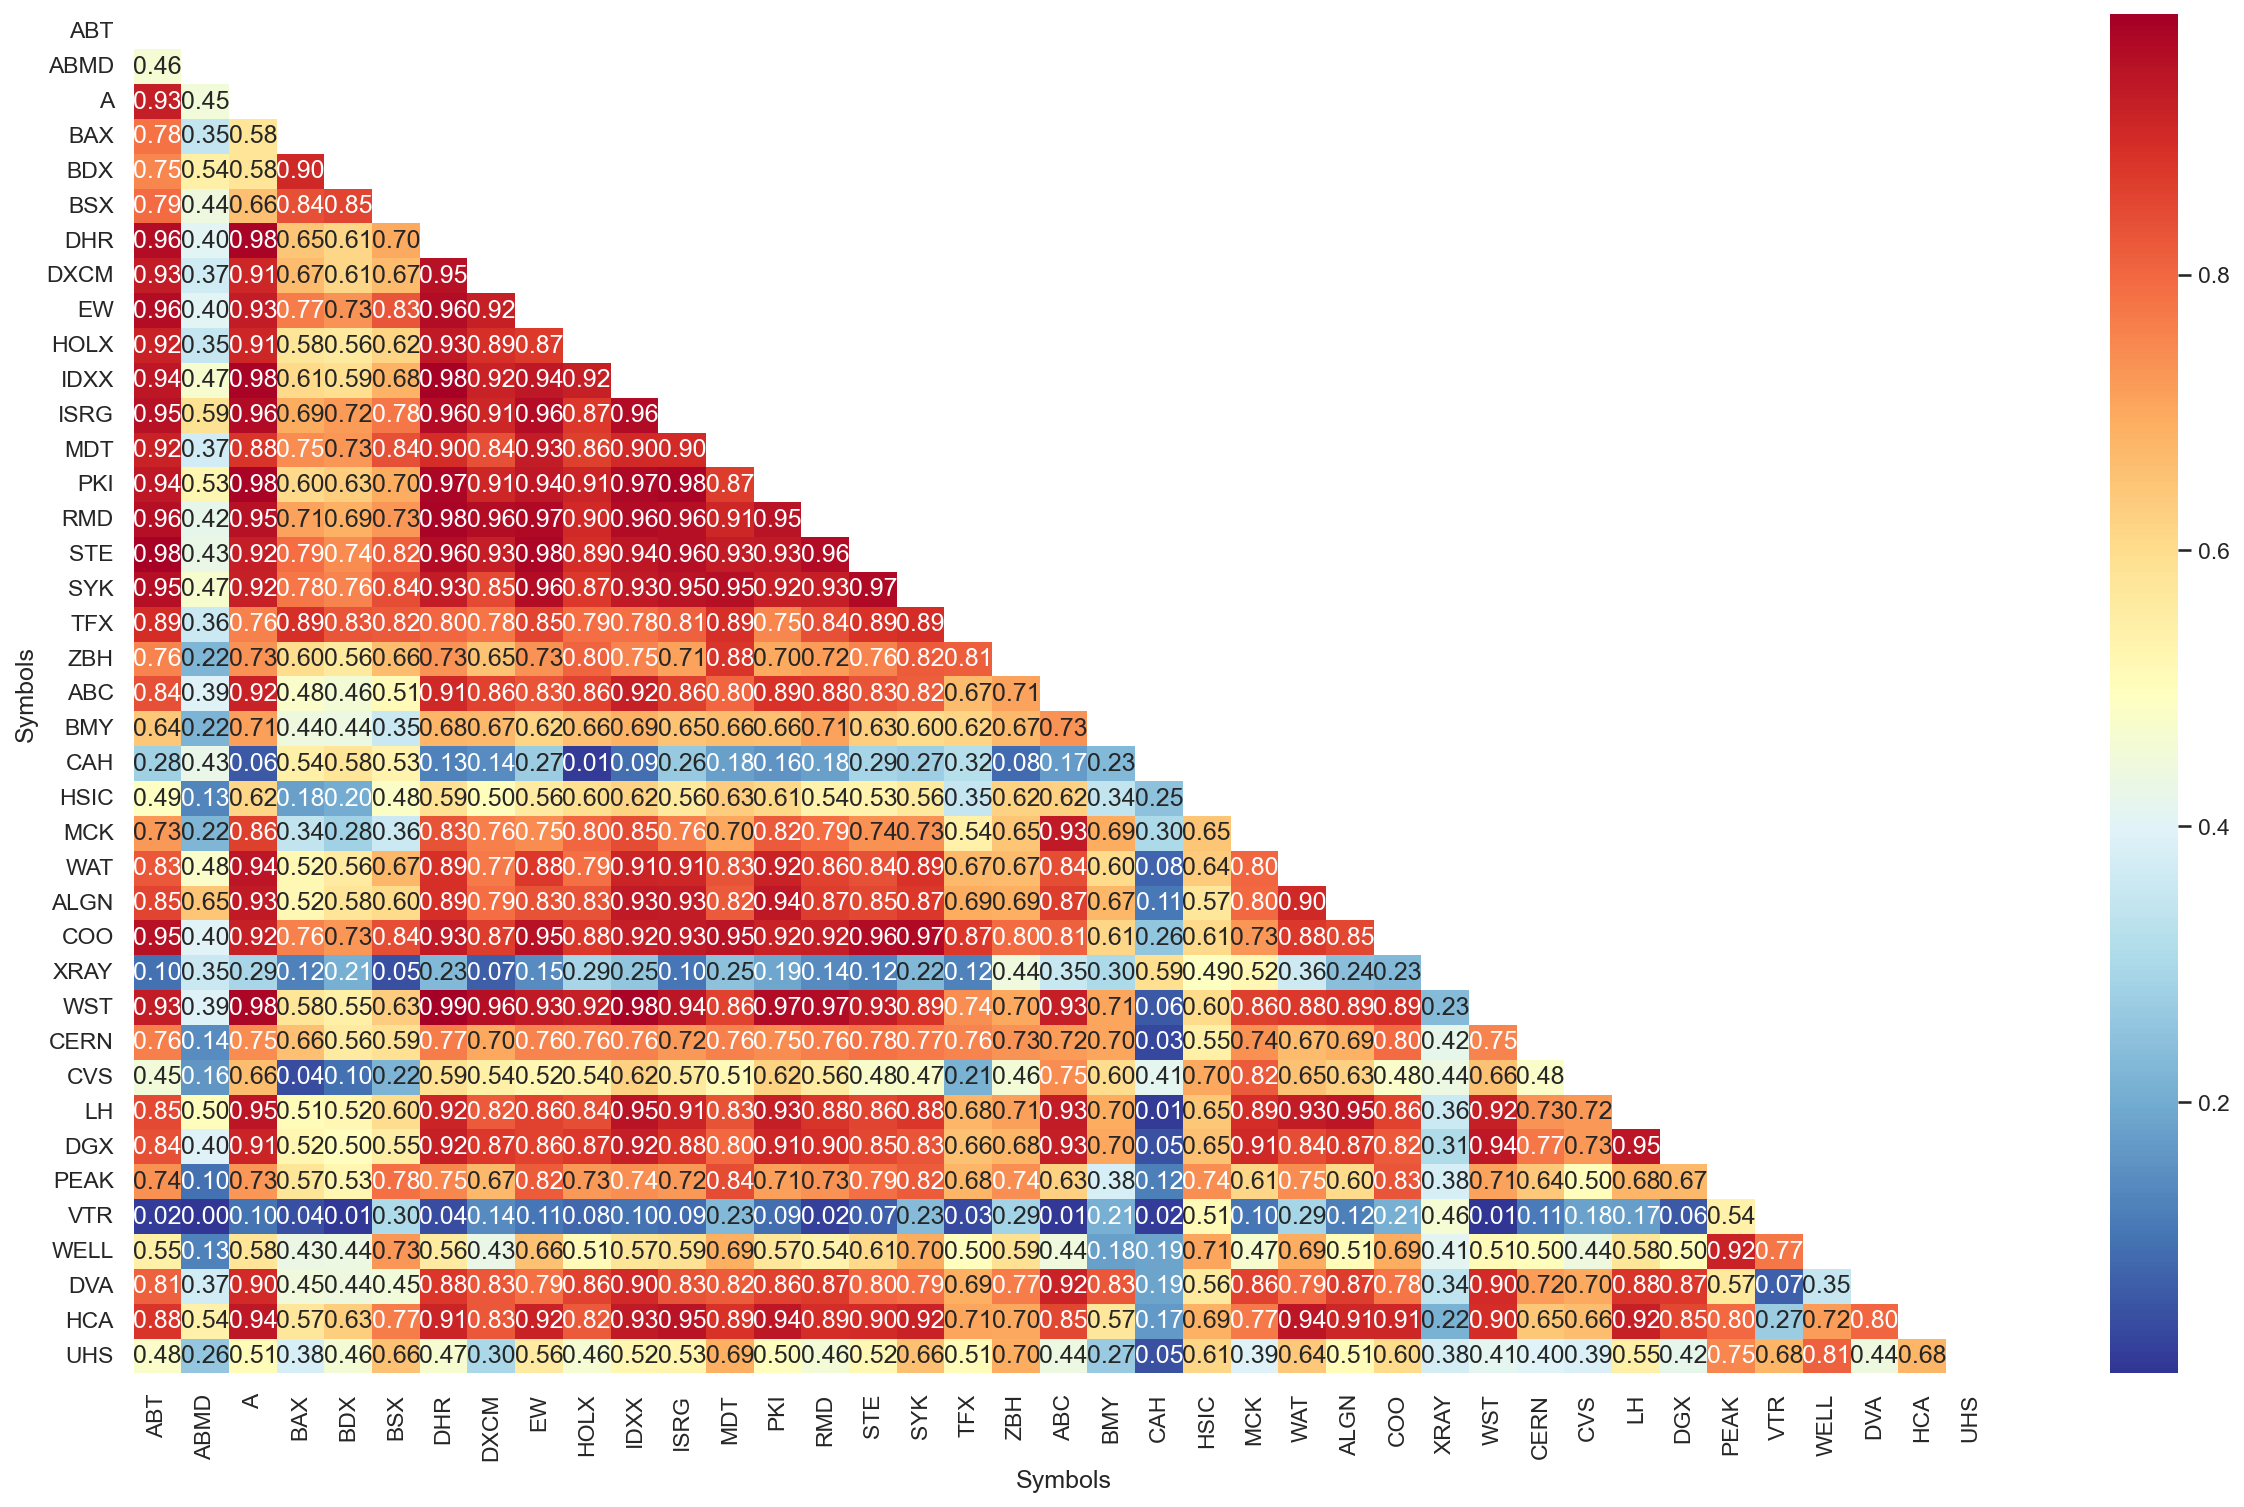

In [97]:
matrix = df.corr().abs()
mask = np.triu(np.ones_like(matrix, dtype = bool))
figure(figsize = (20, 12), dpi = 150)
sns.heatmap(matrix, annot = True, fmt = '.2f', cmap = 'RdYlBu_r', mask = mask)

Now find a pair that speaks to you and run through the numbers. BDX (Becton, Dickson & Co.) and BAX (Baxter International Inc.) look like a promising pair.

In [48]:
stock1 = 'BDX'
stock2 = 'BAX'

S1 = df[stock1]
S2 = df[stock2]

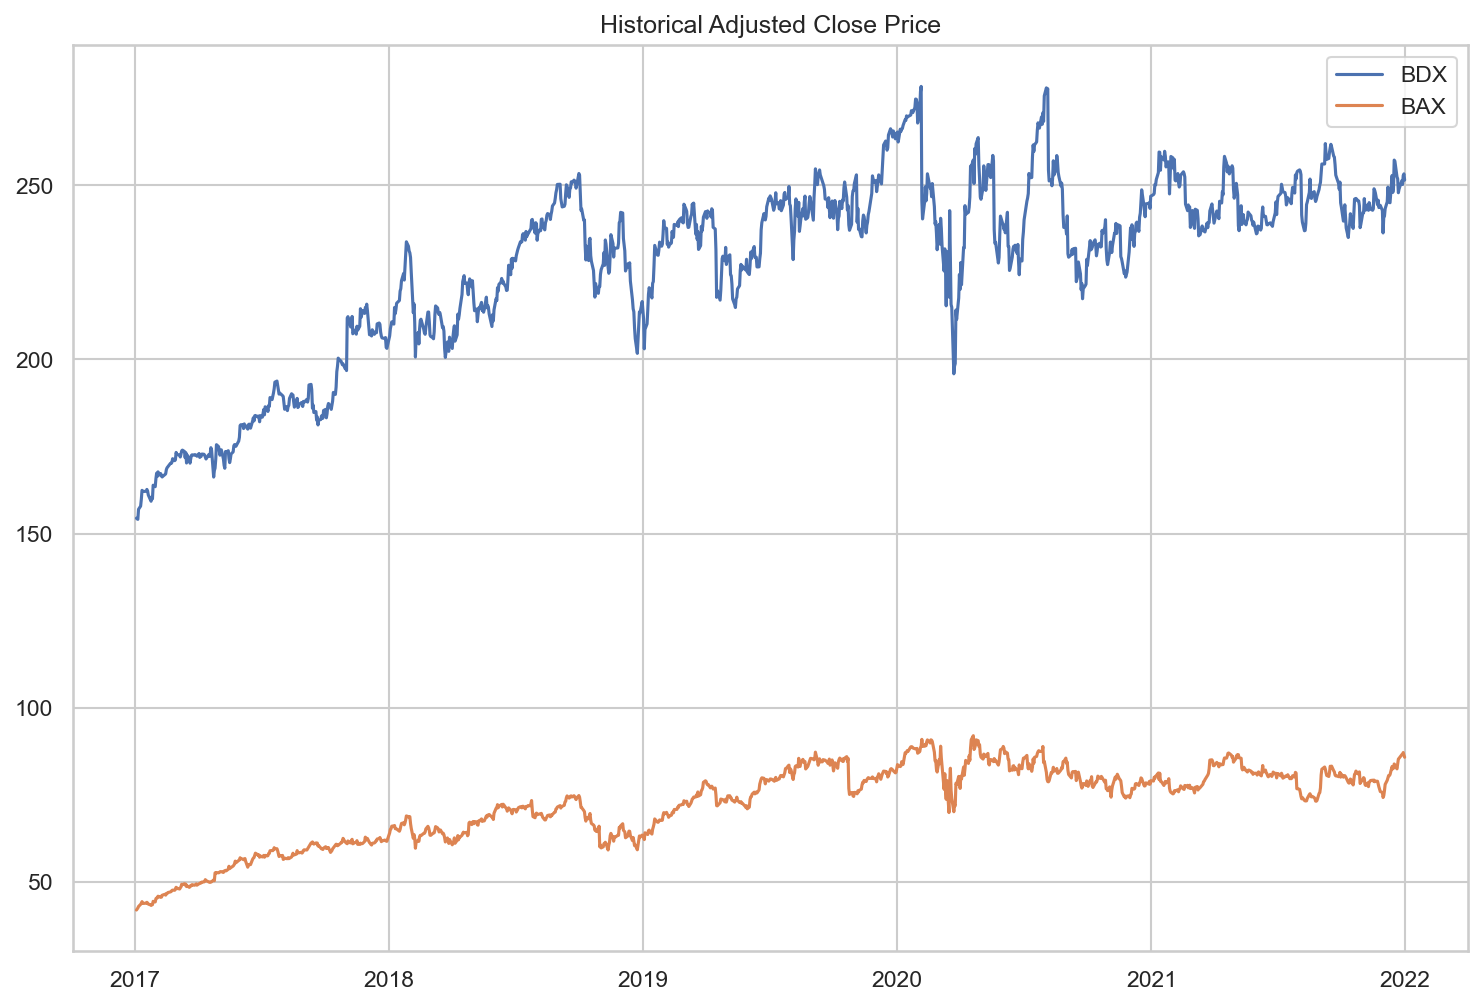

In [49]:
figure(figsize = (12, 8), dpi = 150)
plt.plot(S1, label = stock1)
plt.plot(S2, label = stock2)
plt.title('Historical Adjusted Close Price')
plt.legend()

Text(0.5, 1.0, 'BDX - BAX Spread')

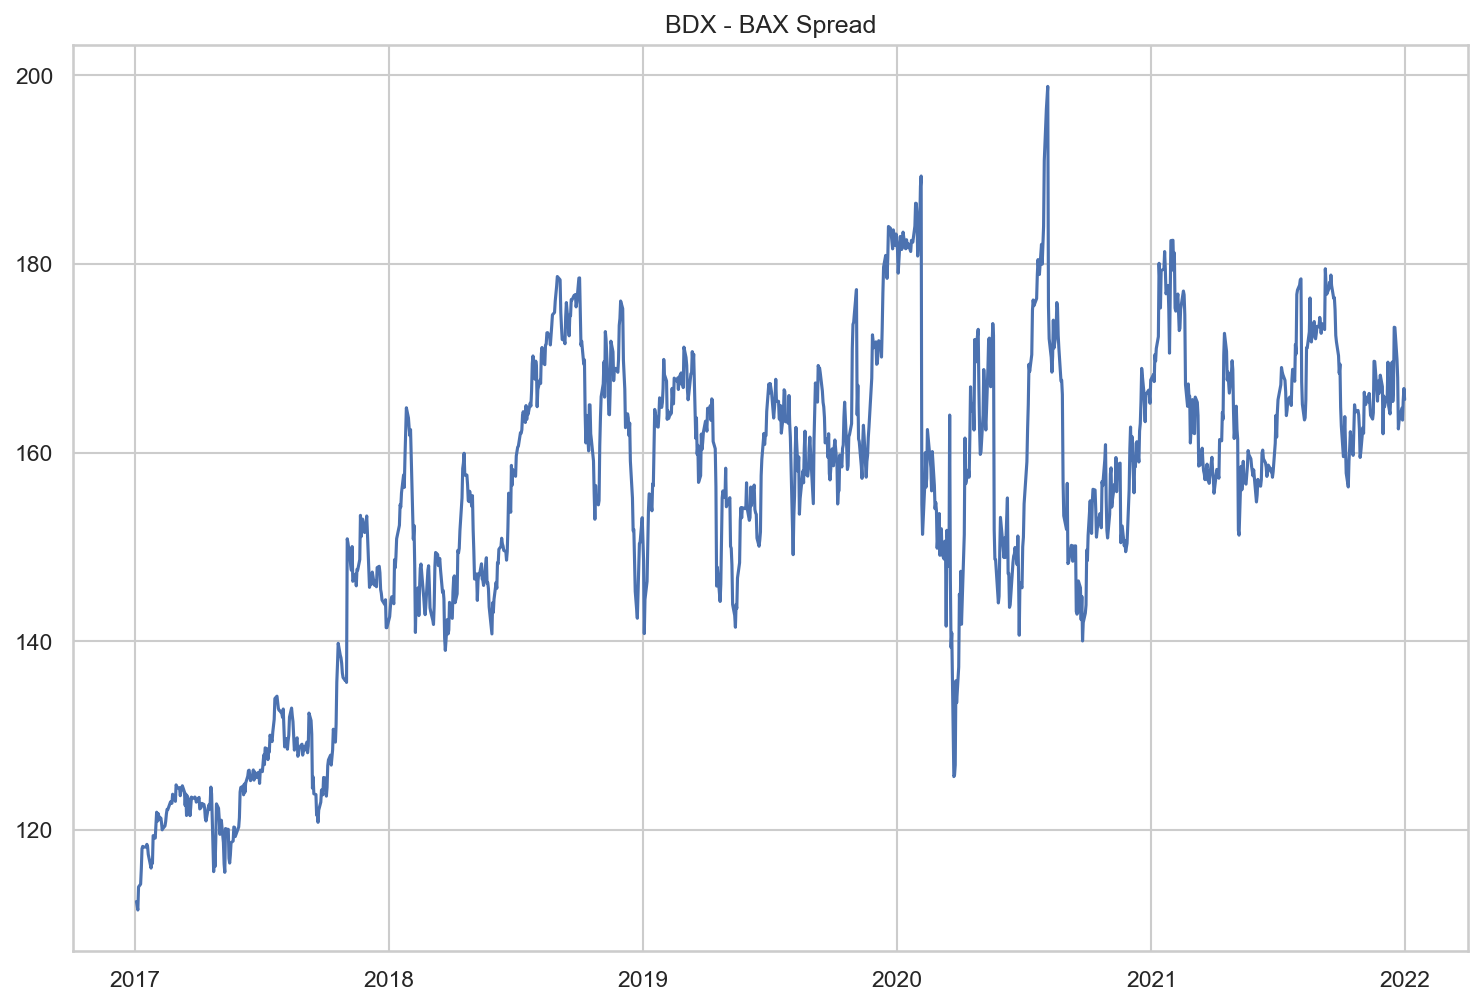

In [50]:
figure(figsize = (12, 8), dpi = 150)
plt.plot(S1 - S2)
plt.title(f'{stock1} - {stock2} Spread')

After plotting charts comparing the two stocks' prices as well as their spread, we see that this pair looks like a promising candidate. Before we continue, we have one more test that we want to compute. This strategy will only work if the pair's ratio fluctuates around a stationary value. To determine that, we use cointegration. If the p-value of the cointegration is less than 0.05, then we're in business.

In [65]:
coint_result = ts.coint(S1, S2)
pvalue = coint_result[1]

if pvalue < 0.05: print(f'P-value is {pvalue}, therefore this pair is cointegrated.')

P-value is 0.002427316369961068, therefore this pair is cointegrated.


Text(0.5, 1.0, 'BDX and BAX Price Ratio')

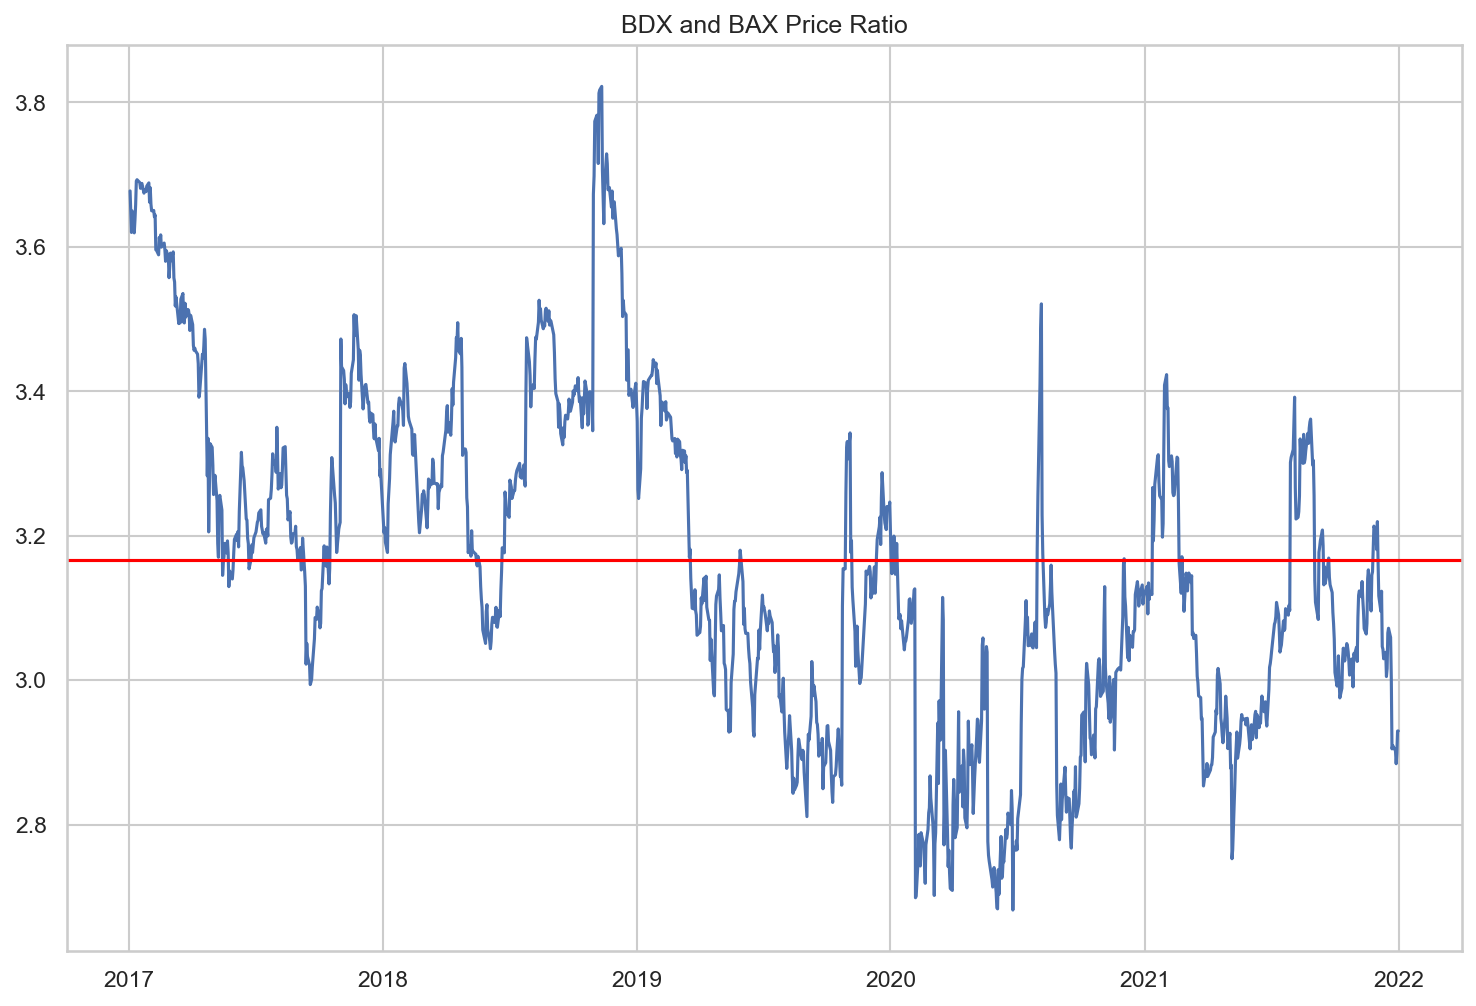

In [52]:
figure(figsize = (12, 8), dpi = 150)
ratio = S1 / S2
plt.plot(ratio, label = f'Price Ratio ({S1} / {S2}))')
plt.axhline(ratio.mean(), color='red')
plt.title(f'{stock1} and {stock2} Price Ratio')

## Calculating Z-Scores

The idea behind this strategy is to buy the ratio (buy stock 1 and sell stock 2) once the ratio of the two deviates more than 1 standard deviation away from the stationary mean value. To make this easier, we will normalize the standard deviations to a z-score. Recall that the equation for the z-score is

$$z = \frac{x-\mu}{\sigma}$$

Now, we construct a chart, this time with lines along the $\pm1$ value.

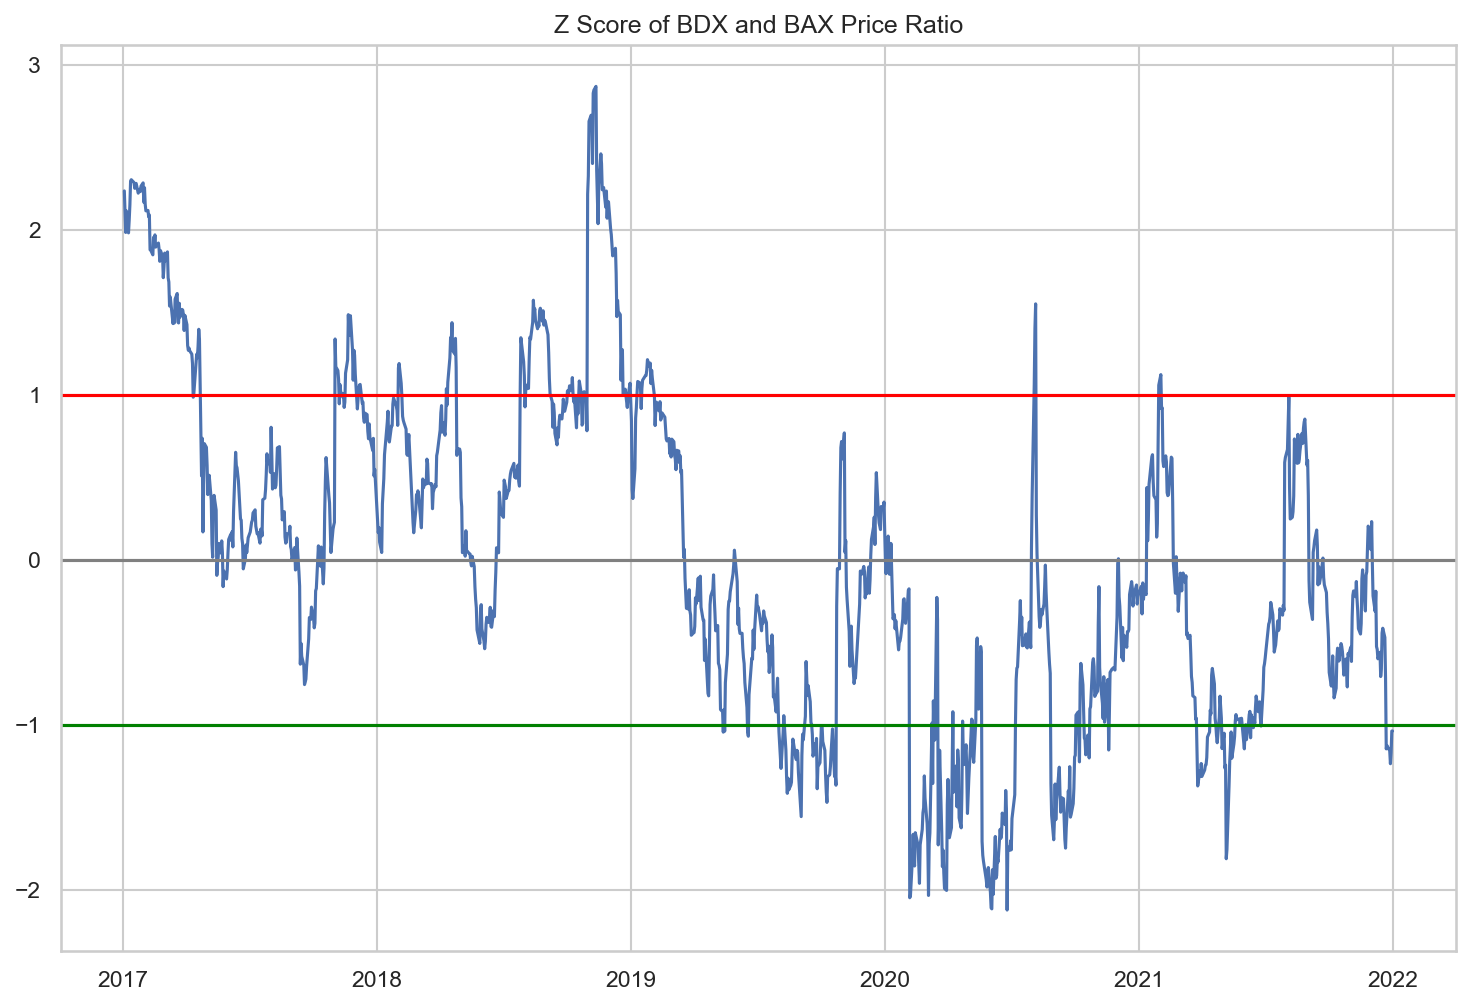

In [70]:
figure(figsize = (12, 8), dpi = 150)
zscores = (ratio - ratio.mean())/ratio.std()
plt.plot(zscores)
plt.axhline(1.0, color = 'red')
plt.axhline(zscores.mean(), color = 'grey')
plt.axhline(-1.0, color = 'green')
plt.title(f'Z Score of {stock1} and {stock2} Price Ratio')
plt.show()

## Trading Signals

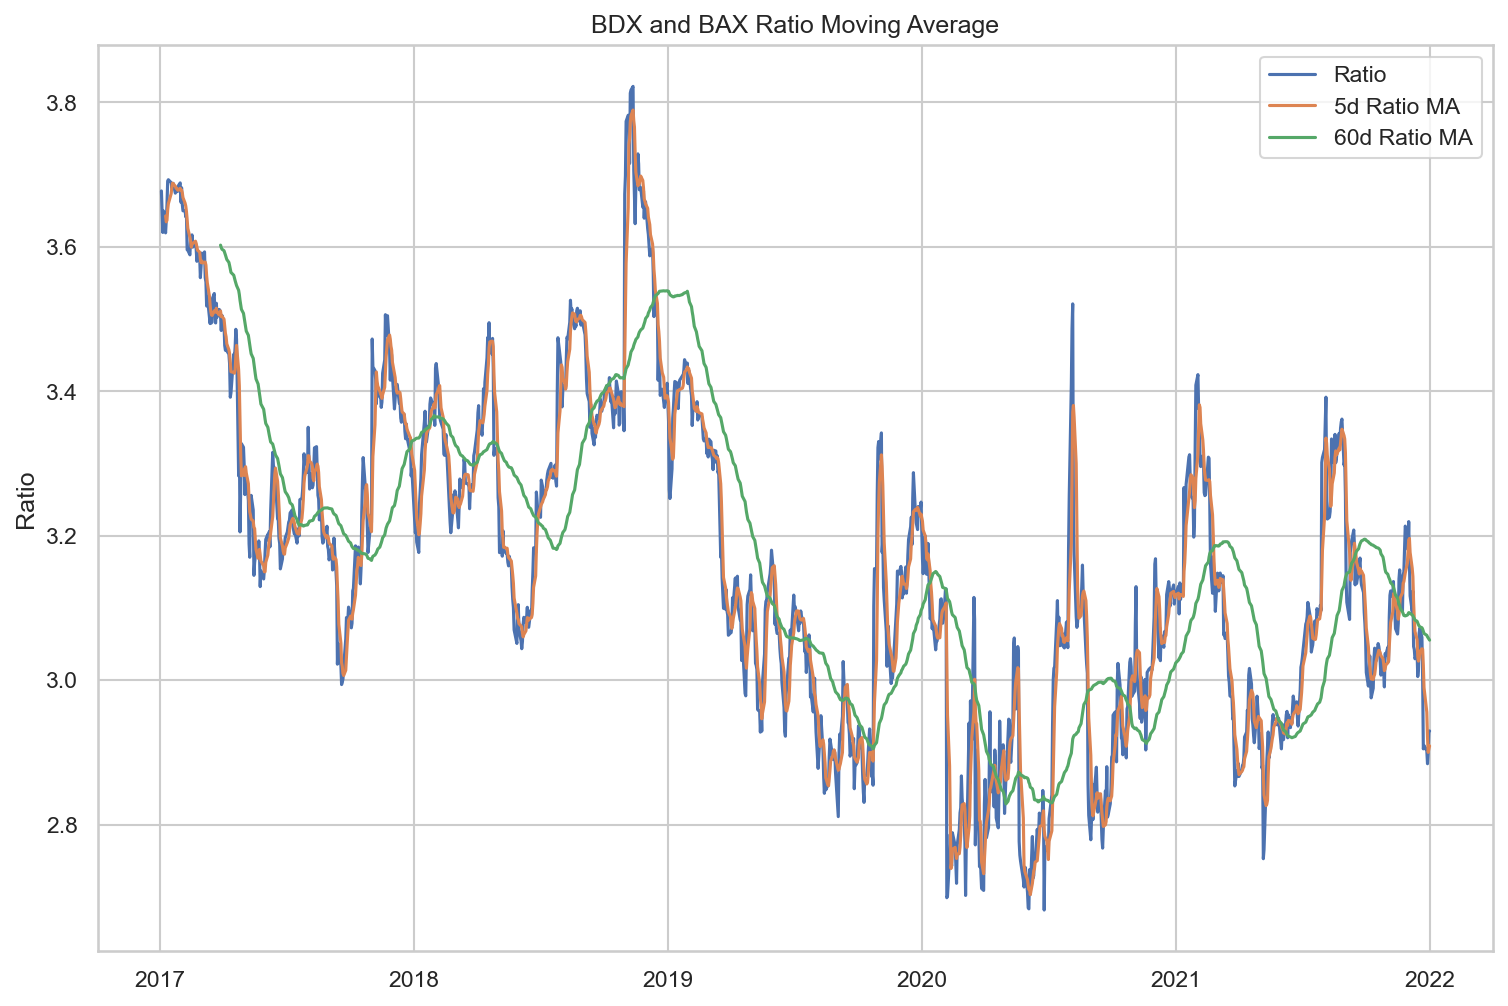

In [79]:
figure(figsize = (12, 8), dpi = 150)
ratios_mavg5d = ratio.rolling(window = 5, center = False).mean()
ratios_mavg60d = ratio.rolling(window = 60, center = False).mean()
std_60 = ratio.rolling(window = 60, center = False).std()
zscore_60_5 = (ratios_mavg5d - ratios_mavg60d)/std_60
plt.plot(ratio.index, ratio.values)
plt.plot(ratios_mavg5d.index, ratios_mavg5d.values)
plt.plot(ratios_mavg60d.index, ratios_mavg60d.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])
plt.ylabel('Ratio')
plt.title(f'{stock1} and {stock2} Ratio Moving Average')
plt.show()

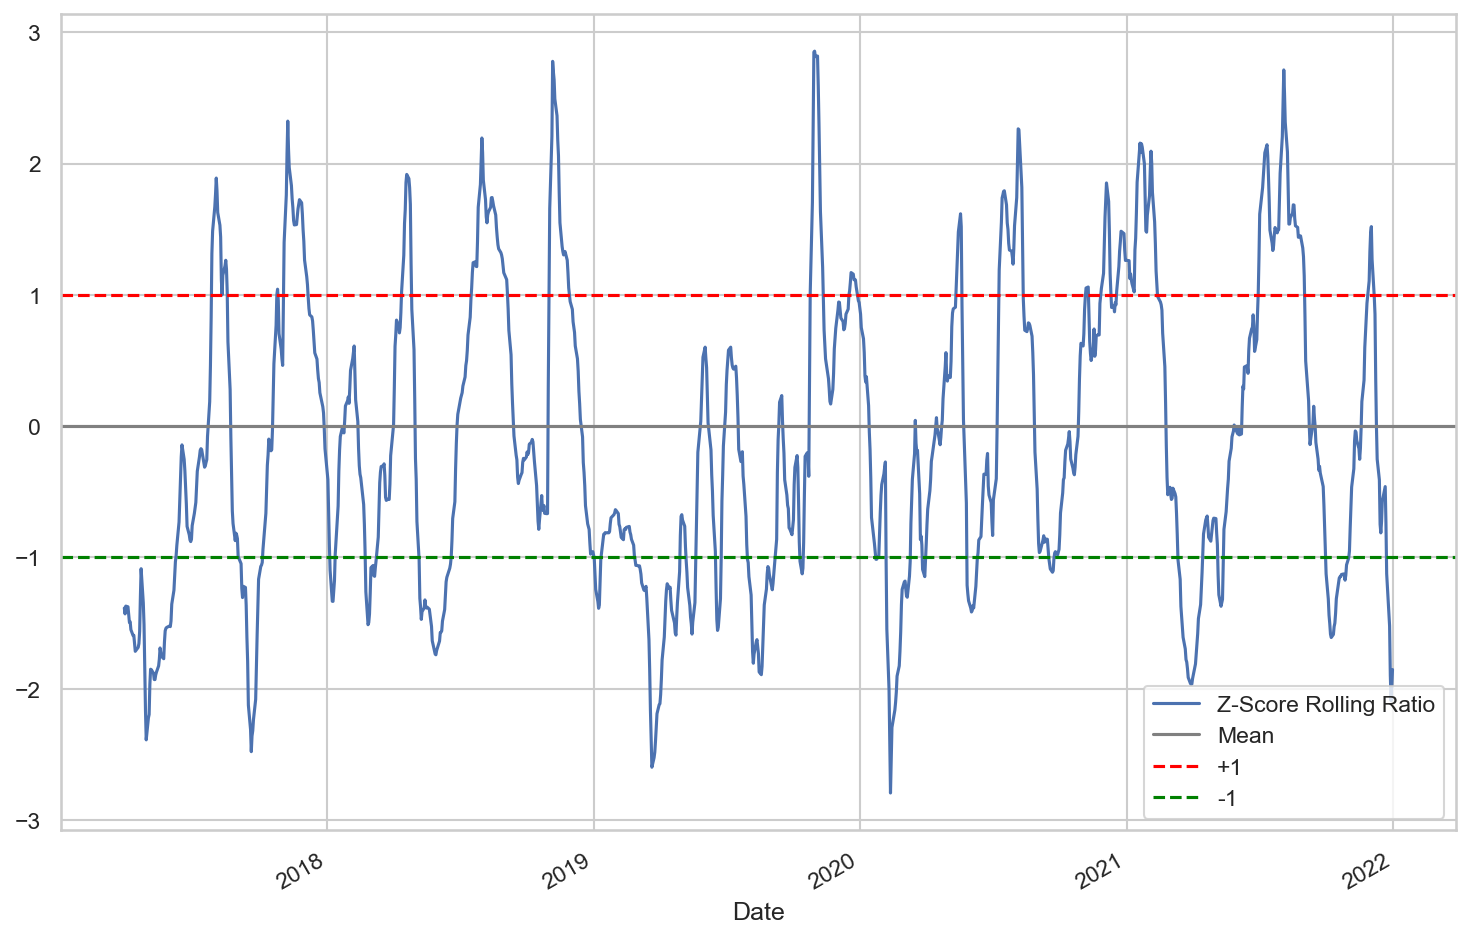

In [82]:
figure(figsize = (12, 8), dpi = 150)
zscore_60_5.plot()
plt.axhline(0, color = 'grey')
plt.axhline(1.0, color = 'red', linestyle = '--')
plt.axhline(-1.0, color = 'green', linestyle = '--')
plt.legend(['Z-Score Rolling Ratio', 'Mean', '+1', '-1'])
plt.show()

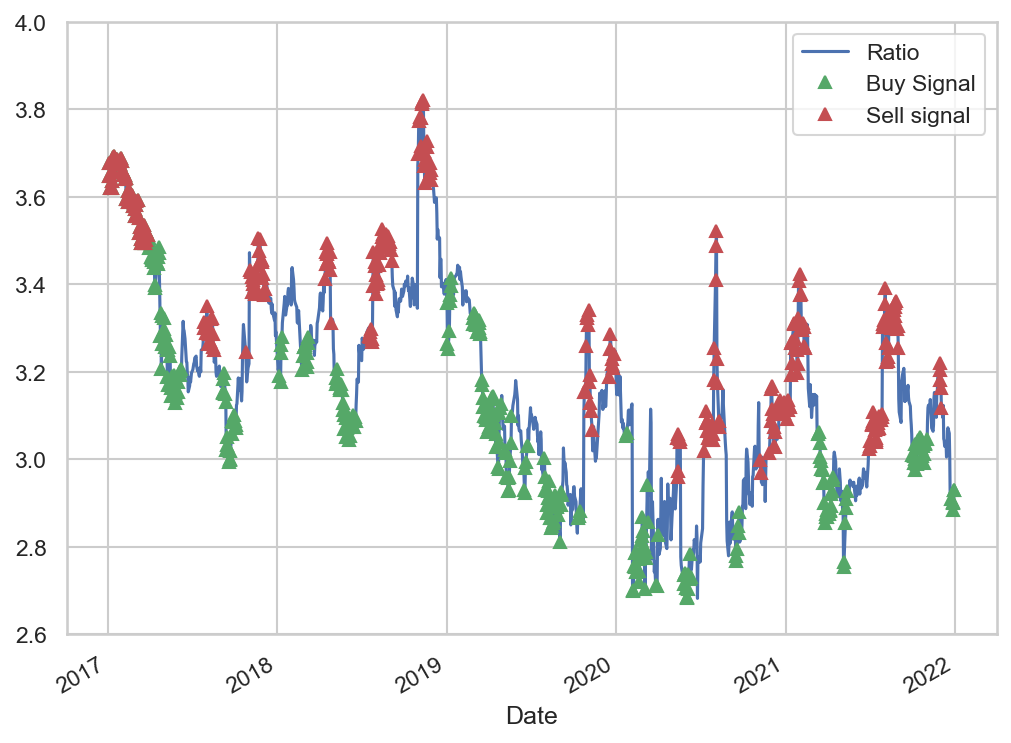

In [88]:
figure(figsize = (8, 6), dpi = 150)
ratio.plot()
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_60_5 > -1] = 0
sell[zscore_60_5 < 1] = 0
buy.plot(color = 'g', linestyle = 'None', marker = '^')
sell.plot(color = 'r', linestyle = 'None', marker = '^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.ylim(2.6, 4)
plt.legend(['Ratio', 'Buy Signal', 'Sell signal'])
plt.show()